In [1]:
from datetime import date, timedelta
from constants import *
from bars import plot_bars as plot_areas, unique_people_tested, daily_vaccinations, population_vaccinated
from phe import *
from phe import map_data as phe_map_data, latest_changes
from zoe import latest_map_data as zoe_map_data
from plotting import *
from vaccination import vaccination_dashboard, vaccination_changes
for_date = '*'

In [2]:
latest_changes(s.new_cases_sum, s.new_admissions_sum, s.new_deaths_sum)

Latest for England:
2,706 cases (7 day average) as of Sun 30 May, +101.3 since Sat 29 May
90 hospitalised (7 day average) as of Tue 01 Jun, +3.9 since Mon 31 May
6 died (7 day average) as of Sun 30 May, +0.4 since Sat 29 May


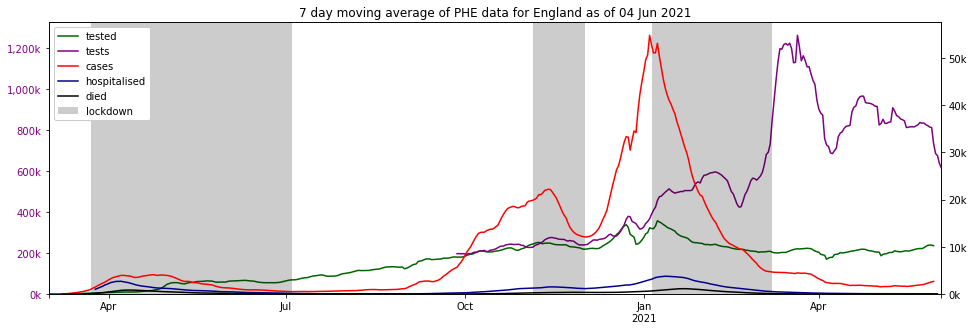

In [3]:
plot_summary(left_series=(s.unique_people_tested_sum, s.new_virus_tests_sum),
             right_series=(s.new_cases_sum, s.new_admissions_sum, s.new_deaths_sum))

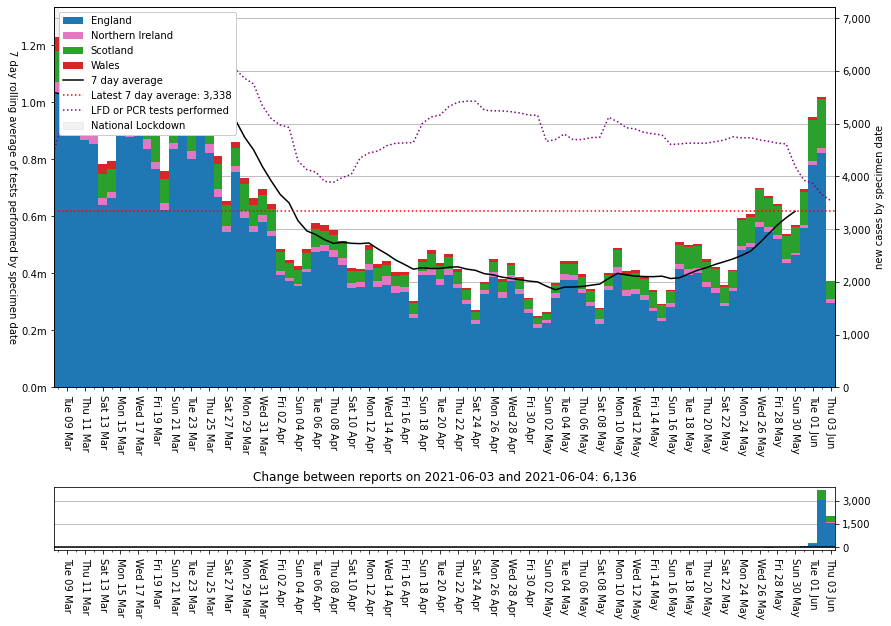

In [4]:
plot_areas(for_date, 'cases_nations', earliest=lockdown3[1], date_format='%a %d %b')

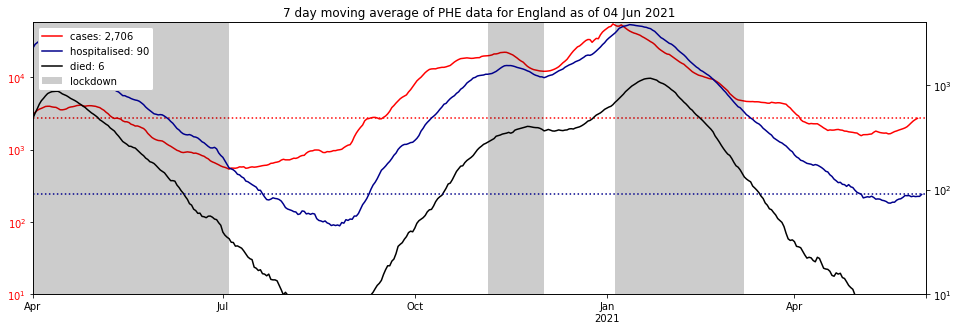

In [5]:
plot_summary(earliest_date='2020-04-01', show_latest='lines', log=True,
             left_series=(s.new_cases_sum,), left_formatter=per1k_formatter,
             right_series=(s.new_admissions_sum, s.new_deaths_sum), right_formatter=per0k_formatter)

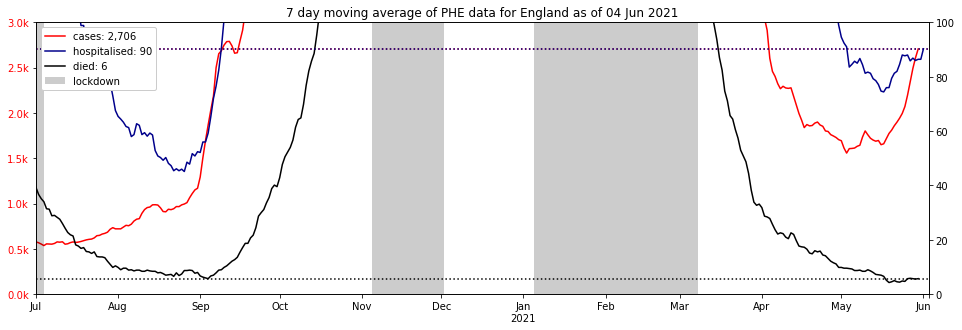

In [6]:
plot_summary(earliest_date='2020-07-01', show_latest='lines',
             left_series=(s.new_cases_sum,), left_formatter=per0k_formatter, left_ymax=3_000,
             right_series=(s.new_admissions_sum, s.new_deaths_sum), right_formatter=per0_formatter, right_ymax=100)

In [7]:
vaccination_changes()

,,Complete (Total),First Dose (Total),Second Dose (Total),Complete (New),First Dose (New),Second Dose (New)
,,,,,,,
England,03 Jun 21,"+22,755,909","+33,375,148","+22,755,909","+313,526","+157,335","+313,526"
Northern Ireland,03 Jun 21,"+692,206","+1,078,917","+692,206","+7,808","+5,142","+7,808"
Scotland,03 Jun 21,"+2,170,570","+3,326,005","+2,170,570","+32,952","+20,193","+32,952"
Wales,03 Jun 21,"+1,181,259","+2,169,624","+1,181,259","+23,355","+8,596","+23,355"


,areaName,areaCode,full,any,partial,population,full_pct,partial_pct,none_pct
0,England,E92000001,22755909.0,33375148.0,10619239.0,56286961,40.428384,18.866250,40.705365
1,Northern Ireland,N92000002,692206.0,1078917.0,386711.0,1893667,36.553734,20.421278,43.024988
2,Scotland,S92000003,2170570.0,3326005.0,1155435.0,5463300,39.730017,21.149031,39.120953
3,Wales,W92000004,1181259.0,2169624.0,988365.0,3152879,37.466043,31.348016,31.185941


'partial: 39,949,694 (59.8%), full: 26,799,944'

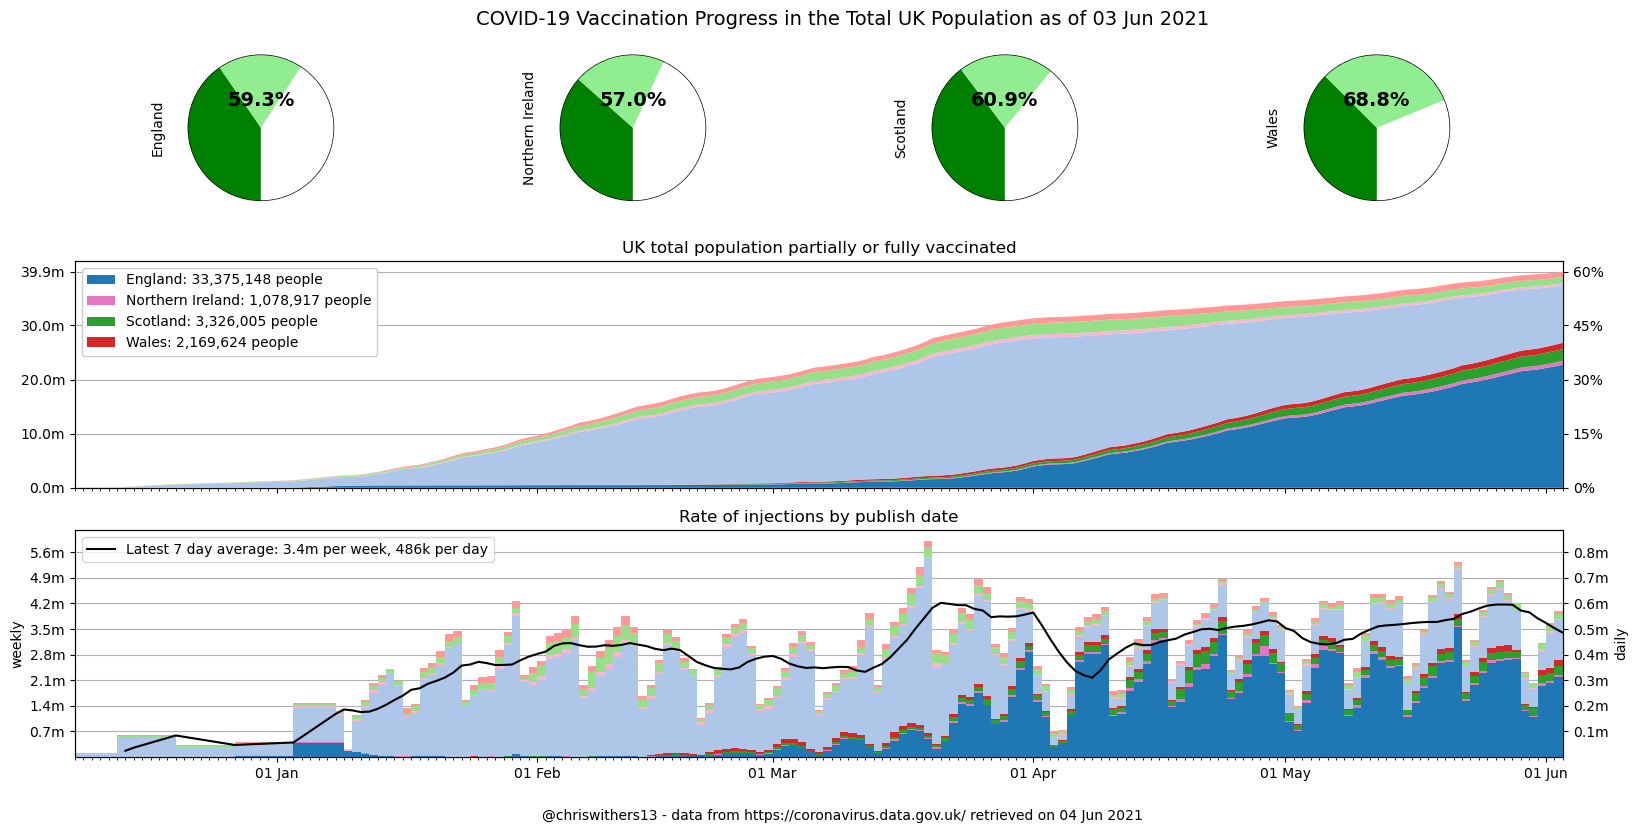

In [8]:
results = vaccination_dashboard()
partial = results['any'].sum()
population = results['population'].sum()
display(results, f"partial: {partial:,.0f} ({partial/population:.1%}), full: {results['full'].sum():,.0f}")

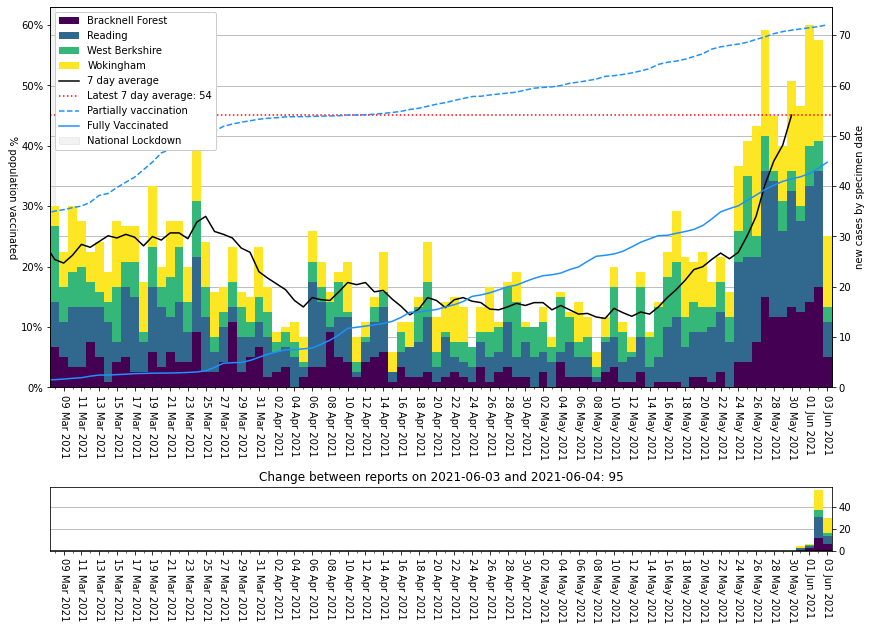

In [9]:
plot_areas(for_date, areas=my_areas, earliest=lockdown3[1],  lines=population_vaccinated)

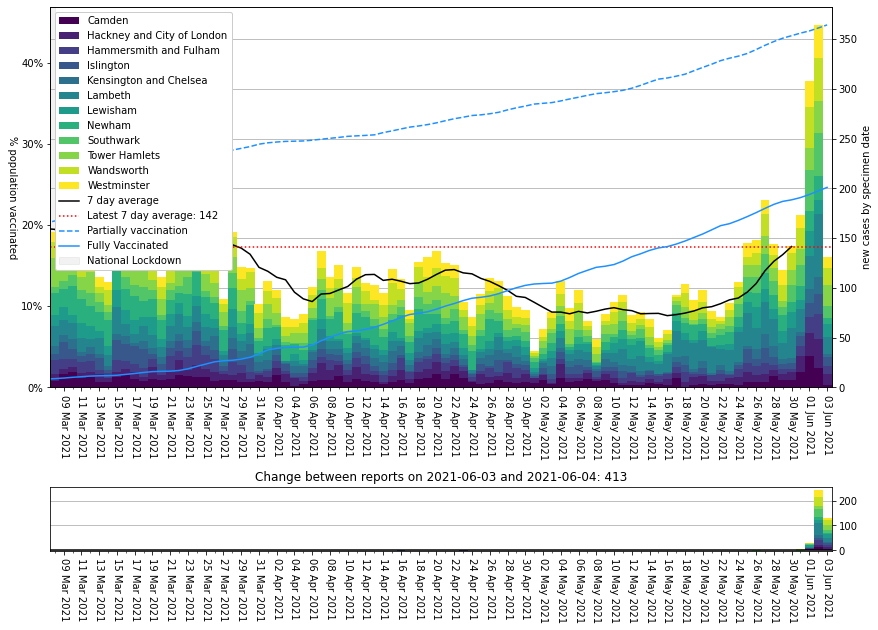

In [10]:
plot_areas(for_date, areas=london_areas, earliest=lockdown3[1], lines=population_vaccinated)

In [11]:
data = recent_phe_data_summed(for_date)
top_10_cols = [area_name,per100k,new_cases_by_specimen_date, specimen_date]

In [12]:
top_10 = data.sort_values(per100k, ascending=False)[:10][top_10_cols]
top_10

,areaName,"per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
E06000008,Blackburn with Darwen,447.573749,670.0,2021-06-03
E08000001,Bolton,264.301861,760.0,2021-06-03
E07000125,Rossendale,250.412691,179.0,2021-06-03
E07000120,Hyndburn,207.297361,168.0,2021-06-03
E07000117,Burnley,188.933873,168.0,2021-06-03
E08000006,Salford,174.629299,452.0,2021-06-03
E08000003,Manchester,169.663820,938.0,2021-06-03
E07000126,South Ribble,159.764595,177.0,2021-06-03
S12000028,South Ayrshire,158.067667,178.0,2021-06-03


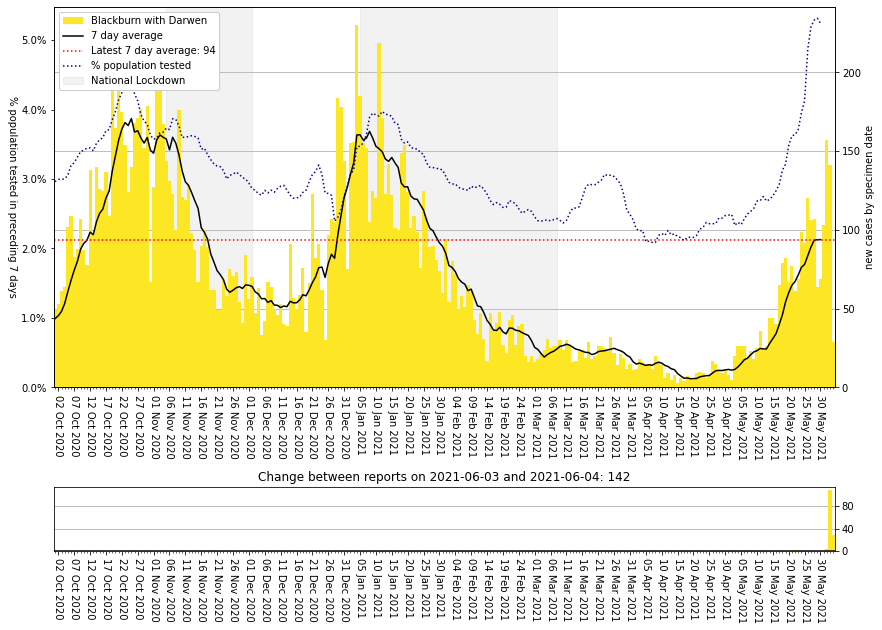

In [13]:
plot_areas(for_date, areas=[top_10.iloc[0].name], colormap='viridis_r', lines=unique_people_tested)

In [14]:
top_10 = data.sort_values(new_cases_by_specimen_date, ascending=False)[:10][top_10_cols]
top_10

,areaName,"per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
E08000003,Manchester,169.663820,938.0,2021-06-03
S12000049,Glasgow City,131.096790,830.0,2021-06-03
E08000001,Bolton,264.301861,760.0,2021-06-03
S12000036,City of Edinburgh,130.112586,683.0,2021-06-03
E06000008,Blackburn with Darwen,447.573749,670.0,2021-06-03
E08000025,Birmingham,47.643403,544.0,2021-06-03
E08000035,Leeds,59.006051,468.0,2021-06-03
E08000006,Salford,174.629299,452.0,2021-06-03
E08000007,Stockport,139.730014,410.0,2021-06-03


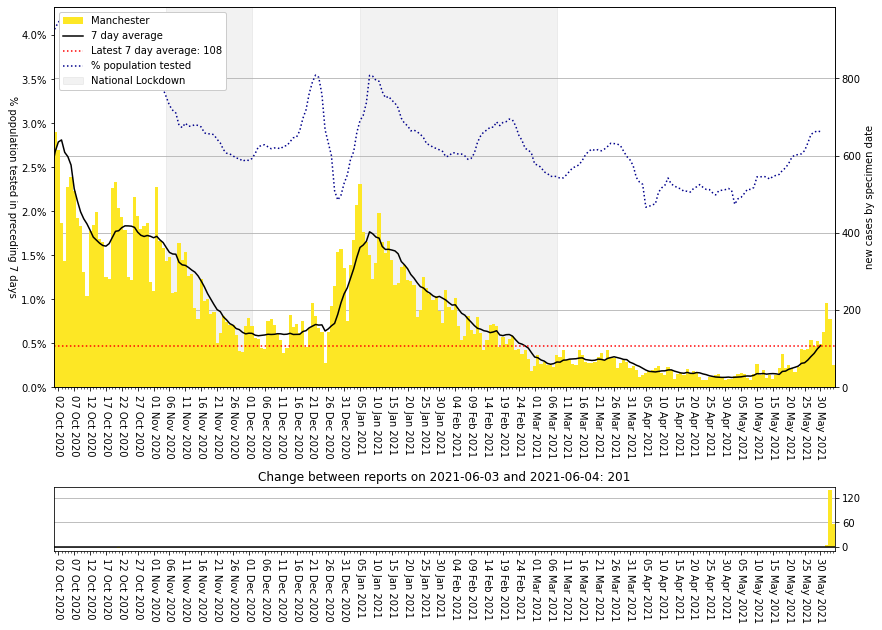

In [15]:
plot_areas(for_date, areas=[top_10.iloc[0].name], colormap='viridis_r', lines=unique_people_tested)

In [16]:
zoe_date, zoe_df = zoe_map_data()
phe_recent_date, phe_recent_geo, phe_recent_title = phe_map_data(for_date)
zoe_max = 0.6
phe_max = 0.25

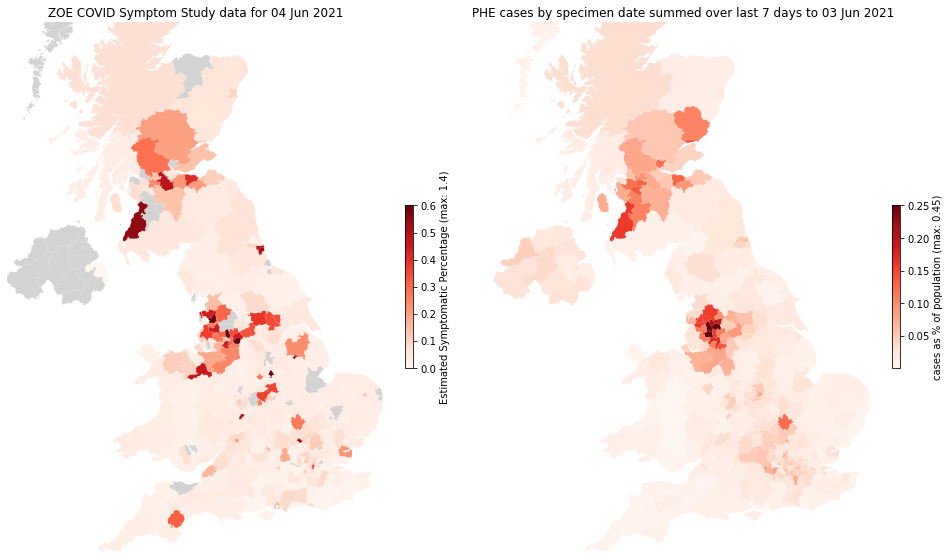

In [17]:
matplotlib_zoe_vs_phe_map(zoe_df, zoe_date, zoe_max, phe_recent_geo, phe_recent_title, phe_max)

In [18]:
bokeh_zoe_vs_phe_map(zoe_df, zoe_date, zoe_max, phe_recent_geo, phe_recent_title, phe_max)

Loading BokehJS ...